In [141]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem

from scipy.stats import multivariate_normal
from scipy.stats import norm as normal
from scipy.stats import gamma

from firedrake.petsc import PETSc

import os
from pathlib import Path

from tqdm import tqdm

In [203]:
%matplotlib inline

import matplotlib.pyplot as plt

global_plot_format = "eps"

# fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'meeting-notes' / '2020-04-27-images'
fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'misc-notes' / 'lhs-uncertainty-images'

A4_INCHES_X = 8.3
A4_INCHES_Y = 11.7

font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [204]:
# experiment_label = 'theta_prior_logdetA_trick'
experiment_label = 'basic'

mc_num_samples = 1_000_000

mcmc_num_samples = 30_000
num_samples_warmup = int(0.2 * mcmc_num_samples)

em_num_samples = 50

In [3]:
class ThetaPriorGamma:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self):
        return gamma.rvs(self.a, scale=self.b)
    
    def logpdf(self, theta):
        return gamma.logpdf(theta, self.a, scale=self.b)
    
class LogThetaPriorNormal:
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

    def sample(self):
        return np.random.normal(self.loc, self.scale)
    
    def logpdf(self, log_theta):
        return normal.logpdf(log_theta, self.loc, self.scale)
    

def theta_proposal_logpdf(theta_from, theta_to, prop_std):
    return normal.logpdf(theta_to, theta_from, prop_std)

def theta_proposal_sample(theta, prop_std):
    return np.random.normal(theta, prop_std)

In [128]:
is_prior_logscale = True

if is_prior_logscale:
    theta_prior = LogThetaPriorNormal(0, 1)
    theta_prior_tex_label = "$\\log \\theta \\sim \\mathcal{N}(0, 1)$"
else:
    theta_prior = ThetaPriorGamma(1, 1)
    theta_prior_tex_label = "$\\theta \\sim$ Gamma$(0, 1)$"

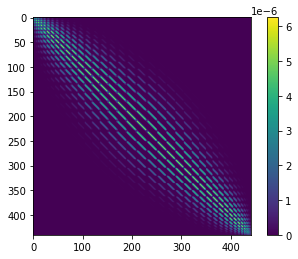

In [5]:
nx = 21

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

M = mesh.coordinates.vector().dat.data.shape[0]

u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)
# f.interpolate(Constant(10))
f.interpolate(-(8*pi*pi)*sin(x[0]*pi*2)*sin(x[1]*pi*2))
# f.interpolate(10 + 5 * (sin(2 * pi * x[0]) + sin(2 * pi * x[1])))


L = f * v * dx
b = assemble(L)
b_np = b.vector().dat.data

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]

log_sigma_f = np.log(1)
log_l_f = np.log(0.1)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=1e-10)
G.assemble()
G_np = G.G.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))

plt.imshow(G_np)
plt.colorbar()

## Monte Carlo estimate

In [ ]:
u_samples_mc = np.zeros((mc_num_samples, M))

u_trial = TrialFunction(V)
v = TestFunction(V)

for n in tqdm(range(mc_num_samples)):
    theta_n = theta_prior.sample()
    if is_prior_logscale:
        theta_n = np.exp(theta_n)
    
    a = (dot(grad(v), Constant(theta_n) * grad(u_trial))) * dx
    A = assemble(a, bcs=bc)
    u_mean = Function(V)
    solve(A, u_mean, b)
    
    u_samples_mc[n, :] = u_mean.vector().dat.data.copy()

if is_prior_logscale:
    np.save(f"MC_samples_{mc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy", u_samples_mc)
else:
    np.save(f"MC_samples_{mc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy", u_samples_mc)

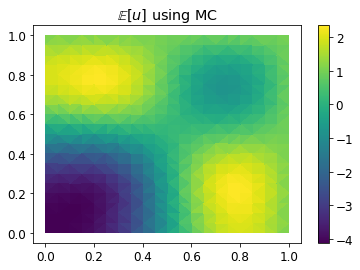

In [191]:
fig, ax = plt.subplots()
u_mean_plot_mc = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              np.mean(u_samples_mc, axis=0))
ax.set_title("$\\mathbb{E}[u]$ using MC")
fig.colorbar(u_mean_plot_mc)
plt.show()

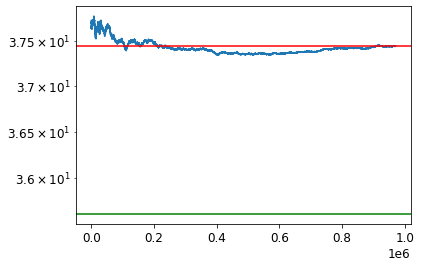

In [212]:
fig, ax = plt.subplots()
ax.plot(mc_cum_mean_norm[30_000:])
ax.axhline(np.linalg.norm(u_samples_em[-1], ord=2), c='green')
ax.axhline(mc_cum_mean_norm[-1], c='red')
mc_cum_mean_norm
ax.set_yscale('log')

## MCMC

In [ ]:
def log_likelihood(u: np.ndarray, 
                   b: np.ndarray,
                   A: np.ndarray, 
                   G: np.ndarray, include_det=True):
    if include_det:
        (_, log_det) = np.linalg.slogdet(A) # A is pos. definite so sign ignored
        result = log_det
    else:
        result = 0
    result += np.dot(u, np.dot(A, np.linalg.solve(G, b)))
    result = result -0.5 * np.dot(u, np.dot(A, np.linalg.solve(G, np.dot(A, u))))
    return result

u_samples_mcmc = np.zeros((mcmc_num_samples, M))
theta_samples_mcmc = np.zeros(mcmc_num_samples)

warmup_interval_check = 50

accepted = 0

theta = np.exp(np.random.normal(0, 1e-1))
u = np.zeros(M)

prop_std = 1e-2 # initial value for the std of the proposal

for n in tqdm(range(mcmc_num_samples)):
    # Recalibrate proposal density for ω
    if n < num_samples_warmup and  ((n + 1) % warmup_interval_check == 0):
        ar = float(accepted) / float(warmup_interval_check)
        if ar < 0.4:
            print(f"AR = {ar} - rescaling the proposal density.")
            prop_std -= .1 * prop_std
            prop_std = np.abs(prop_std)
        elif ar > 0.6:
            print(f"AR = {ar} - rescaling the proposal density.")
            prop_std += .1 * prop_std 
        accepted = 0
  
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), theta_constant * grad(u_trial))) * dx, bcs=bc)
    
    u_mean = Function(V)
    solve(A, u_mean, b) # firedrake solve
    
    A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    A_inv_np = np.linalg.inv(A_np)
    u_cov = A_inv_np @ G_np @ A_inv_np

    # 1. sample from p(u|theta) using a closed form expression
    u = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)
    
    # 2. sample from p(theta|u) via a Metropolis-step
    theta_star = theta_proposal_sample(theta, prop_std)
    
    if is_prior_logscale or theta_star > 0: # enforce the positivty
        u_trial = TrialFunction(V)
        v = TestFunction(V)
        theta_star_constant = Constant(np.exp(theta_star)) if is_prior_logscale else Constant(theta_star)
        A_star = assemble((dot(grad(v), theta_star_constant * grad(u_trial))) * dx, bcs=bc)
        A_star_np = A_star.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
        A_star_inv_np = np.linalg.inv(A_star_np)

        u_mean_star = Function(V)
        solve(A_star, u_mean_star, b) # firedrake solve
        u_cov_star = A_star_inv_np @ G_np @ A_star_inv_np

        log_p_u_given_theta_star = log_likelihood(u, b_np, A_star_np, G_np, include_det=True)
        log_p_u_given_theta = log_likelihood(u, b_np, A_np, G_np, include_det=True)

        log_ar = log_p_u_given_theta_star + theta_prior.logpdf(theta_star) + theta_proposal_logpdf(theta_star, theta, prop_std)
#         log_ar = log_p_u_given_theta_star + theta_proposal_logpdf(theta_star, theta, prop_std)
        log_ar = log_ar - log_p_u_given_theta - theta_prior.logpdf(theta) - theta_proposal_logpdf(theta, theta_star, prop_std)
#         log_ar = log_ar - log_p_u_given_theta - theta_proposal_logpdf(theta, theta_star, prop_std)

        if np.exp(log_ar) > np.random.uniform(0, 1):
            accepted += 1
            theta = theta_star

    theta_samples_mcmc[n] = theta
    u_samples_mcmc[n, :] = u
    
if is_prior_logscale:
    np.save(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy", u_samples_mcmc)
else:
    np.save(f"MCMC_samples_{mcmc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy", u_samples_mcmc)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.linalg.norm(u_samples_mcmc, axis=1, ord=2))
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\Vert u_n \\Vert_2$')
ax.set_xlabel('$n$')
ax.set_title("Samples of $u$")
plt.show()

fig, ax = plt.subplots()
u_mean_plot_mcmc = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                                mesh.coordinates.vector().dat.data[:, 1],
                                np.mean(u_samples_mcmc[num_samples_warmup:], axis=0))
ax.set_title("$\\mathbb{E}[u]$ using MCMC")
fig.colorbar(u_mean_plot_mcmc)
plt.show()

fig, ax = plt.subplots()
ax.plot(np.exp(theta_samples_mcmc[num_samples_warmup:]) if is_prior_logscale else theta_samples_mcmc[num_samples_warmup:])
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\theta_n$')
ax.set_xlabel('$n$')
ax.set_title('Samples of $\\theta$')
plt.show()

# EM

In [205]:
from scipy.optimize import minimize_scalar as minimize

def e_step(theta):
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), Constant(theta_constant) * grad(u_trial))) * dx, bcs=bc)
    
    u_mean = Function(V)
    solve(A, u_mean, b) # firedrake solve
    return u_mean.vector().dat.data

def m_step(theta, u_np, G, b_np, include_det=True):
   
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), theta_constant * grad(u_trial))) * dx, bcs=bc)
    
    A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    G_np = G.G.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    
    if include_det:
        (_, log_det) = np.linalg.slogdet(A_np) # A is pos. definite so sign ignored
        result = log_det
        result += theta_prior.logpdf(theta)
    else:
        result = 0
    
    result += np.dot(u_np, np.dot(A_np, np.linalg.solve(G_np, b_np)))
    result = result -0.5 * np.dot(u_np, np.dot(A_np, np.linalg.solve(G_np, np.dot(A_np, u_np))))
    
    return -1 * result

theta = 10

u_samples_em = np.zeros((em_num_samples, M))
theta_samples_em = np.zeros(em_num_samples)
             
for n in tqdm(range(em_num_samples)):
    
    current_u = e_step(theta)
    u_samples_em[n, :] = current_u.copy()
    
    if is_prior_logscale:
        opt_result = minimize(m_step, args=(current_u, G, b_np, True))  
    else:
        opt_result = minimize(m_step, args=(current_u, G, b_np, True), bounds=(0, np.inf), method='bounded')
    theta = opt_result.x
    theta_samples_em[n] = theta
    
if is_prior_logscale:
    np.save(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}", u_samples_em)
else:
    np.save(f"EM_samples_{em_num_samples}_gamma_prior_nx_{nx}_{experiment_label}", u_samples_em)    

100%|██████████| 50/50 [00:19<00:00,  2.50it/s]


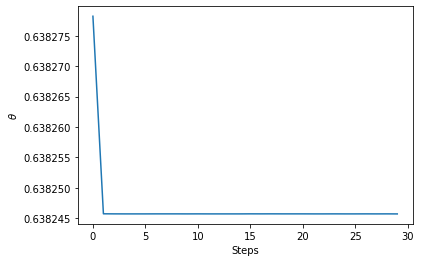

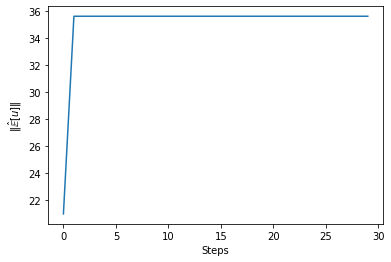

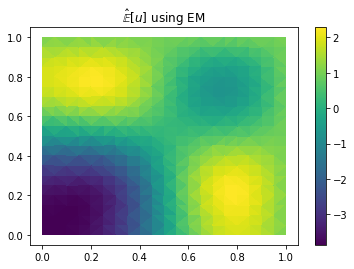

In [118]:
fig, ax = plt.subplots()
ax.plot(np.exp(theta_samples_em) if is_prior_logscale else em_theta_samples)
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\theta$')
ax.set_xlabel('Steps')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.linalg.norm(u_samples_em, axis=1, ord=2))
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\Vert \hat{\\mathbb{E}}[u] \\Vert$')
ax.set_xlabel('Steps')
plt.show()

fig, ax = plt.subplots()
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              u_samples_em[-1])
ax.set_title("$\\hat{\\mathbb{E}}[u]$ using EM")
fig.colorbar(u_mean_plot_em)
plt.show()

# Convergence analysis

## $\log \theta \sim \mathcal{N}(0, 1)$ vs $p(\theta) \propto \vert A_\theta^{-1} \vert$

In [76]:
u_samples_mcmc_logdet = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_theta_prior_logdetA_trick.npy")
u_samples_mcmc_normal = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_basic.npy")
em_u_samples_logdet = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_theta_prior_logdetA_trick.npy")
em_u_samples_normal = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_basic.npy")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


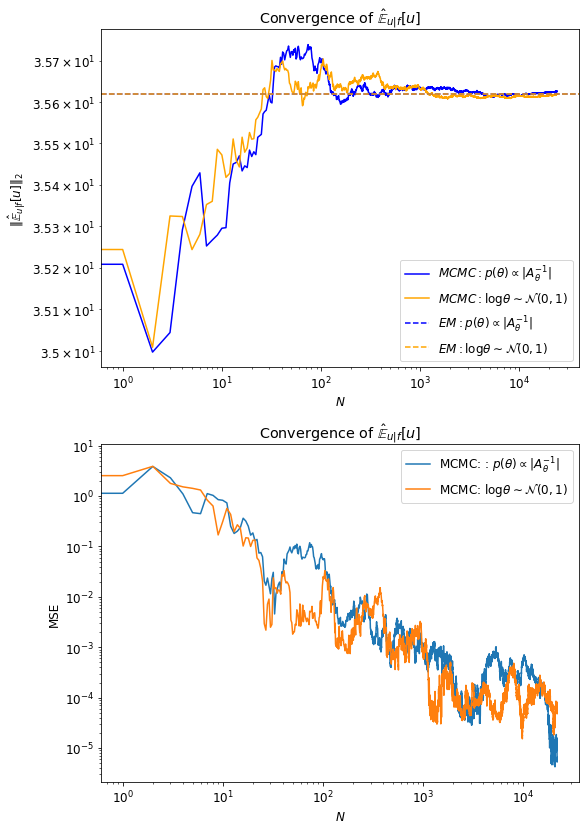

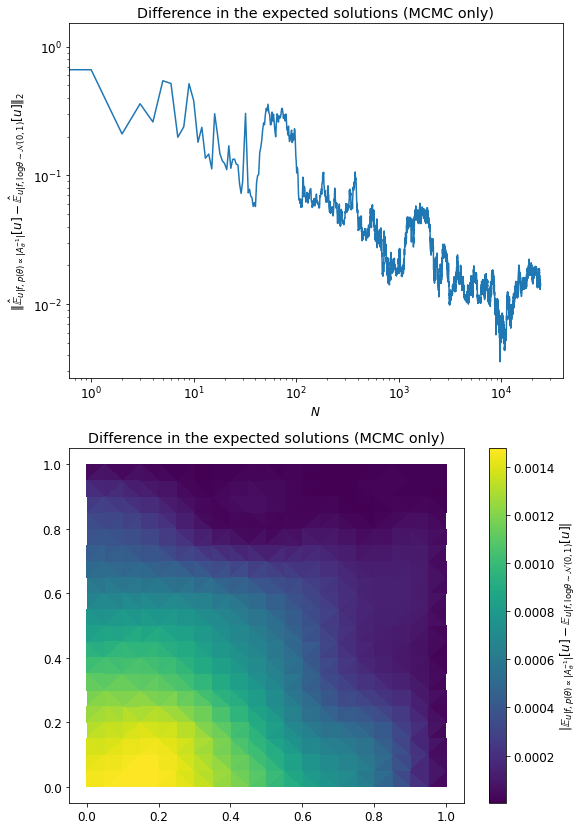

In [188]:
mcmc_cum_mean_logdet = np.cumsum(u_samples_mcmc_logdet[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]
mcmc_cum_mean_normal = np.cumsum(u_samples_mcmc_normal[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]

mcmc_cum_mse_logdet = np.sum(np.square(mcmc_cum_mean_logdet - mcmc_cum_mean_logdet[-1][np.newaxis, :]), axis=1)
mcmc_cum_mse_normal = np.sum(np.square(mcmc_cum_mean_normal - mcmc_cum_mean_normal[-1][np.newaxis, :]), axis=1)

max_N = mcmc_cum_mean_logdet.shape[0]
selected_range = np.arange(0, max_N)

global_plot_format = 'eps'

# convergence to the solution and MSE
fig, ax = plt.subplots(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y), nrows=2, ncols=1)
ax[0].plot(selected_range, np.linalg.norm(mcmc_cum_mean_logdet[selected_range], axis=1, ord=2), color='blue')
ax[0].plot(selected_range, np.linalg.norm(mcmc_cum_mean_normal[selected_range], axis=1, ord=2), color='orange')
ax[0].axhline(np.linalg.norm(em_u_samples_logdet[-1], ord=2), color='blue', linestyle='--')
ax[0].axhline(np.linalg.norm(em_u_samples_normal[-1], ord=2), color='orange', linestyle='--')
ax[0].legend(['$MCMC: p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', '$MCMC: \\log \\theta \\sim \\mathcal{N}(0, 1)$', 
           '$EM: p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', '$EM: \\log \\theta \\sim \\mathcal{N}(0, 1)$'])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('$\Vert \\hat{\\mathbb{E}}_{u|f}[u] \Vert_2$')
ax[0].set_xlabel('$N$')
ax[0].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$")

ax[1].plot(selected_range[:-2000], mcmc_cum_mse_logdet[selected_range[:-2000]])
ax[1].plot(selected_range[:-2000], mcmc_cum_mse_normal[selected_range[:-2000]])
ax[1].legend(['MCMC: : $p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', 'MCMC: $\\log \\theta \\sim \\mathcal{N}(0, 1)$'])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$N$')
ax[1].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$")
plt.tight_layout()
plt.savefig(fig_path / f'logdet-trick-convergence.{global_plot_format}', bbox_inches="tight")
plt.show()

# difference in the estimates

fig = plt.figure(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y))
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

# fig, ax = plt.subplots(figsize=(0.6 * A4_INCHES_X, 0.35 * A4_INCHES_Y), nrows=1, ncols=3)
ax1.plot(selected_range, np.linalg.norm(mcmc_cum_mean_logdet[selected_range] - mcmc_cum_mean_normal[selected_range], axis=1, ord=2))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("$\\Vert \\hat{\\mathbb{E}}_{u|f, p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert}[u] - \\hat{\\mathbb{E}}_{u|f, \\log \\theta \\sim \\mathcal{N}(0, 1)}[u] \\Vert_2 $")
ax1.set_xlabel('$N$')
ax1.set_title("Difference in the expected solutions (MCMC only)")
# plt.savefig(fig_path / f'logdet-trick-solution-difference-norm.{global_plot_format}', bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(figsize=(0.4 * A4_INCHES_X, 0.35 * A4_INCHES_Y))
diff_mcmc_mc_u = ax2.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                               mesh.coordinates.vector().dat.data[:, 1],
                               np.abs(mcmc_cum_mean_normal[-1] - mcmc_cum_mean_logdet[-1]))
cbar = fig.colorbar(diff_mcmc_mc_u)
cbar.ax.set_ylabel('$\\vert \\mathbb{E}_{u|f, p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert}[u] - \\mathbb{E}_{u|f, \\log \\theta \\sim \\mathcal{N}(0, 1)}[u] \\vert $')
ax2.set_title("Difference in the expected solutions (MCMC only)")
plt.tight_layout()
plt.savefig(fig_path / f'logdet-trick-solution-difference.{global_plot_format}', bbox_inches="tight")
plt.show()

## Monte Carlo vs MCMC

In [176]:
if is_prior_logscale:
    u_samples_mc = np.load(f"MC_samples_{mc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_mcmc = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_em = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
else:
    u_samples_mc = np.load(f"MC_samples_{mc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_mcmc = np.load(f"MCMC_samples_{mcmc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_em = np.load(f"EM_samples_{em_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")

mcmc_cum_mean = np.cumsum(u_samples_mcmc[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]
mcmc_cum_mean_norm = np.linalg.norm(mcmc_cum_mean, axis=1, ord=2)
true_mcmc_u_mean = mcmc_cum_mean[-1]
mcmc_cum_mse = np.sum(np.square(mcmc_cum_mean - true_mcmc_u_mean[np.newaxis, :]), axis=1)
    
mc_cum_mean = np.cumsum(u_samples_mc, axis=0) / (1 + np.arange(mc_num_samples))[:, np.newaxis]
mc_cum_mean_norm = np.linalg.norm(mc_cum_mean, axis=1)
true_mc_u_mean = mc_cum_mean[-1]
mc_cum_mse = np.sum(np.square(mc_cum_mean - true_mc_u_mean[np.newaxis, :]), axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


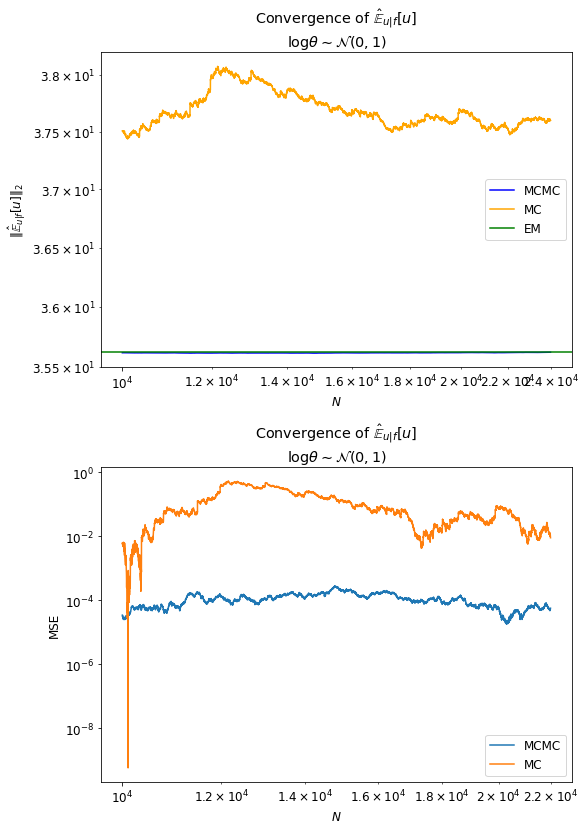

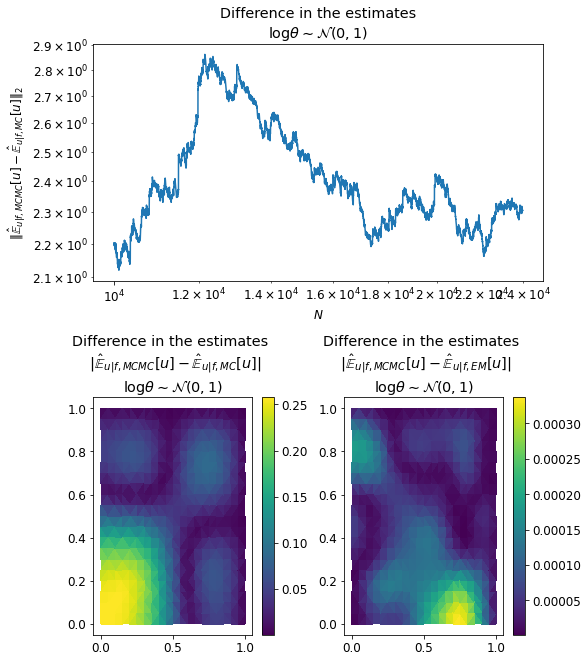

In [211]:
max_N = min(mc_cum_mse.shape[0], mcmc_cum_mse.shape[0])
selected_range = np.arange(10_000, max_N)


# convergence
fig, ax = plt.subplots(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y), nrows=2, ncols=1)
ax[0].plot(selected_range, np.linalg.norm(mcmc_cum_mean[selected_range], axis=1, ord=2), c='blue')
ax[0].plot(selected_range, np.linalg.norm(mc_cum_mean[selected_range], axis=1, ord=2), c='orange')
ax[0].axhline(np.linalg.norm(u_samples_em[-1], ord=2), c='green')
ax[0].legend(['MCMC', 'MC', 'EM'])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('$\Vert \\hat{\\mathbb{E}}_{u|f}[u] \Vert_2$')
ax[0].set_xlabel('$N$')
ax[0].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$ \n" + theta_prior_tex_label)

ax[1].plot(selected_range[:-2000], mcmc_cum_mse[selected_range[:-2000]])
ax[1].plot(selected_range[:-2000], mc_cum_mse[selected_range[:-2000]])
ax[1].legend(['MCMC', 'MC'])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$N$')
ax[1].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$\n" + theta_prior_tex_label)

plt.tight_layout()
plt.savefig(fig_path / f'lognormal_convergence.{global_plot_format}', bbox_inches="tight")
plt.show()


# difference in the estimates
fig = plt.figure(figsize=(1 * A4_INCHES_X, 0.8 * A4_INCHES_Y))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax1.plot(selected_range, np.linalg.norm(mcmc_cum_mean[selected_range] - mc_cum_mean[selected_range], axis=1, ord=2))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("$\\Vert \\hat{\\mathbb{E}}_{u|f, MCMC}[u] - \\hat{\\mathbb{E}}_{u|f, MC}[u] \\Vert_2 $")
ax1.set_xlabel('$N$')
ax1.set_title("Difference in the estimates\n" + theta_prior_tex_label)

diff_mcmc_mc_u = ax2.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                               mesh.coordinates.vector().dat.data[:, 1],
                               np.abs(mcmc_cum_mean[-1] - mc_cum_mean[-1]))
fig.colorbar(diff_mcmc_mc_u, ax=ax2)
ax2.set_title("Difference in the estimates \n $\\vert \hat{\\mathbb{E}}_{u|f, MCMC}[u] - \hat{\\mathbb{E}}_{u|f, MC}[u] \\vert $\n" + theta_prior_tex_label)

diff_mcmc_em_u = ax3.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                               mesh.coordinates.vector().dat.data[:, 1],
                               np.abs(mcmc_cum_mean[-1] - u_samples_em[-1]))
fig.colorbar(diff_mcmc_em_u, ax=ax3)
ax3.set_title("Difference in the estimates \n $\\vert \hat{\\mathbb{E}}_{u|f, MCMC}[u] - \hat{\\mathbb{E}}_{u|f, EM}[u] \\vert $\n" + theta_prior_tex_label)

plt.tight_layout()
plt.savefig(fig_path / f'lognormal_solution_difference.{global_plot_format}', bbox_inches="tight")
plt.show()

## MC vs MCMC convergence

In [ ]:
N_max = 22_000
fig, ax = plt.subplots()
ax.plot(mcmc_cum_mse[:N_max])
ax.plot(mc_cum_mse[:N_max])

# Reference scale
ax.hlines(y_pos, x_pos, x_pos + x_delta, label=f"{x_delta}")
ax.annotate('{:1.0f}'.format(x_delta), (x_pos + 0.4 * x_delta, y_pos - 0.2 * y_delta))
ax.vlines(x_pos, y_pos, y_pos + y_delta, label=f"{y_delta}")
ax.annotate('{:1.0f}'.format(y_delta), (x_pos - 0.5 * x_delta, y_pos + 0.4 * y_delta))
ax.plot((x_pos, x_pos + x_delta), (y_pos + y_delta, y_pos), 'k-')

# Add labels, legend, and adjust scale
ax.legend(['MCMC', 'MC'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('MSE')
ax.set_xlabel('$N$')
ax.set_title("Convergence of $\mathbb{E}_{u|f}[u]$")
plt.show()